In [1]:
import sys
sys.path.append('../code')

from utils import plot_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import torch
import numpy as np
import pickle
import stg_node
from model.dyn_stg import SpatioTemporalGraphCVAEModel
from model.model_registrar import ModelRegistrar
from utils.scene_utils import create_batch_scene_graph

import timeit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from PIL import Image
import imageio
import random
from collections import defaultdict

# Options

In [2]:
hyperparams = {
    ### Training
    ## Batch Sizes
    'batch_size': 16,
    ## Learning Rate
    'learning_rate': 0.001,
    'min_learning_rate': 0.00001,
    'learning_decay_rate': 0.9999,
    ## Optimizer
    # 'optimizer': tf.train.AdamOptimizer,
    'optimizer_kwargs': {},
    'grad_clip': 1.0,

    ### Prediction
    'minimum_history_length': 5,    # 0.5 seconds
    'prediction_horizon': 15,       # 1.5 seconds (at least as far as the loss function is concerned)

    ### Variational Objective
    ## Objective Formulation
    'alpha': 1,
    'k': 3,              # number of samples from z during training
    'k_eval': 50,        # number of samples from z during evaluation
    'use_iwae': False,   # only matters if alpha = 1
    'kl_exact': True,    # relevant only if alpha = 1
    ## KL Annealing/Bounding
    'kl_min': 0.07,
    'kl_weight': 1.0,
    'kl_weight_start': 0.0001,
    'kl_decay_rate': 0.99995,
    'kl_crossover': 8000,
    'kl_sigmoid_divisor': 6,

    ### Network Parameters
    ## RNNs/Summarization
    'rnn_kwargs': {"dropout_keep_prob": 0.75},
    'MLP_dropout_keep_prob': 0.9,
    'rnn_io_dropout_keep_prob': 1.0,
    'enc_rnn_dim_multiple_inputs': 8,
    'enc_rnn_dim_edge': 8,
    'enc_rnn_dim_edge_influence': 8,
    'enc_rnn_dim_history': 32,
    'enc_rnn_dim_future': 32,
    'dec_rnn_dim': 128,
    'dec_GMM_proj_MLP_dims': None,
    'sample_model_during_dec': True,
    'dec_sample_model_prob_start': 0.0,
    'dec_sample_model_prob_final': 0.0,
    'dec_sample_model_prob_crossover': 20000,
    'dec_sample_model_prob_divisor': 6,
    ## q_z_xy (encoder)
    'q_z_xy_MLP_dims': None,
    ## p_z_x (encoder)
    'p_z_x_MLP_dims': 16,
    ## p_y_xz (decoder)
    'fuzz_factor': 0.05,
    'GMM_components': 16,
    'log_sigma_min': -10,
    'log_sigma_max': 10,
    'log_p_yt_xz_max': 50,

    ### Discrete Latent Variable
    'N': 2,
    'K': 5,
    ## Relaxed One-Hot Temperature Annealing
    'tau_init': 2.0,
    'tau_final': 0.001,
    'tau_decay_rate': 0.9999,
    ## Logit Clipping
    'use_z_logit_clipping': False,
    'z_logit_clip_start': 0.05,
    'z_logit_clip_final': 3.0,
    'z_logit_clip_crossover': 8000,
    'z_logit_clip_divisor': 6
}

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cpu'
data_dir = './data'
eval_data_dict_path = 'eval_data_dict.pkl'
model_dir = './logs/models_28_Jan_2019_15_35_20'
robot_node = stg_node.STGNode('0', 'Pedestrian')
hyperparams['dynamic_edges'] = 'yes'
hyperparams['edge_addition_filter'] = [0.25, 0.5, 0.75, 1.0]
hyperparams['edge_removal_filter'] = [1.0, 0.0]
hyperparams['edge_state_combine_method'] = 'sum'
hyperparams['edge_influence_combine_method'] = 'bi-rnn'
hyperparams['edge_radius'] = 1.5

if not torch.cuda.is_available() or device == 'cpu':
    device = torch.device('cpu')
else:
    if torch.cuda.device_count() == 1:
        # If you have CUDA_VISIBLE_DEVICES set, which you should,
        # then this will prevent leftover flag arguments from 
        # messing with the device allocation.
        device = 'cuda:0'

    device = torch.device(device)

print(device)

cpu


# Visualization

In [4]:
with open(os.path.join(data_dir, eval_data_dict_path), 'rb') as f:
    eval_data_dict = pickle.load(f, encoding='latin1')

In [5]:
model_registrar = ModelRegistrar(model_dir, device)
model_registrar.load_models(1999)


Loading from ./logs/models_28_Jan_2019_15_35_20/model_registrar-1999.pt
Loaded!



In [6]:
model_registrar = model_registrar.cpu()

In [7]:
# This keeps colors consistent across timesteps, rerun this cell if you want to reset the colours.
color_dict = defaultdict(dict)

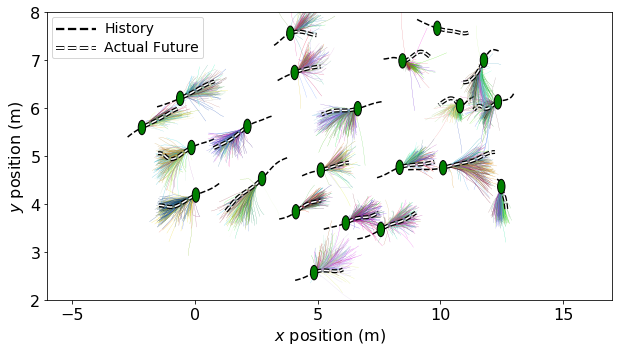

In [8]:
plot_utils.plot_predictions(eval_data_dict, model_registrar,
                            robot_node, hyperparams, 
                            device, dt=eval_data_dict['dt'], max_speed=12.42222,
                            color_dict=color_dict,
                            data_id=11, t_predict=10,
                            figsize=(1.75*5, 5),
                            ylim=(2, 8), xlim=(-6, 17),
                            fig_height=10, 
                            num_samples=200,
                            radius_of_influence=hyperparams['edge_radius'],
                            node_circle_size=0.15,
                            circle_edge_width=1.0, line_alpha=0.9,
                            line_width=0.2, edge_width=4,
                            dpi=300, tick_fontsize=16,
                            robot_circle=None, omit_names=True,
                            legend_loc='best', title=''
                           )